# **DCGAN: Unlearn**

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import time

# # Set random seed for reproducibility
# manualSeed = 5
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

# Kích thước của Latent Vector
nz = 100

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 128, 4, 2, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 4 x 4

            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 7 x 7

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 14 x 14

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.model(input)
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # input is 1 x 28 x 28

            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 32 x 14 x 14

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64) x 7 x 7

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 4 x 4

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [3]:
# Thiết bị sử dụng
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [4]:
criterion = nn.BCELoss()


# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5


In [43]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

G_final = Generator().to(device)
D_final = Discriminator().to(device)
G_adapt = Generator().to(device)
D_adapt = Discriminator().to(device)

# Tải trọng số vào mô hình
save_dir = "checkpoints"
G_final.load_state_dict(torch.load(f'{save_dir}/generator_epoch_final.pth'))
D_final.load_state_dict(torch.load(f'{save_dir}/discriminator_epoch_final.pth'))
G_adapt.load_state_dict(torch.load(f'{save_dir}/generator_adapted_mnist1.pth'))
D_adapt.load_state_dict(torch.load(f'{save_dir}/discriminator_adapted_mnist1.pth'))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(G_final.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(D_final.parameters(), lr=lr, betas=(beta1, 0.999))

cuda:0


C:\Users\Admin\AppData\Local\Temp\ipykernel_6000\176679159.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_final.load_state_dict(torch.load(f'{save_dir}/generator_epo

## **Save a vector corresponding to `1` (WARNING: DO NOT MESS AROUND TOO MUCH!!!!)**

you'll have to find a new vector of `1` by eye!!

torch.Size([64, 100, 1, 1])


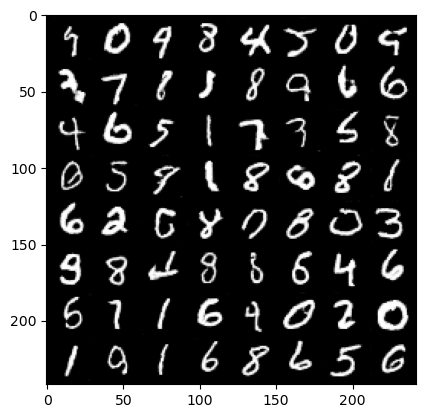

In [29]:
# Create a batch (64) of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
print(fixed_noise.shape)

with torch.no_grad():
    fake = G_final(fixed_noise).detach().cpu()
a = vutils.make_grid(fake, padding=2, normalize=True)
plt.imshow(np.transpose(a,(1, 2, 0)))

Vector saved to vector_1.txt


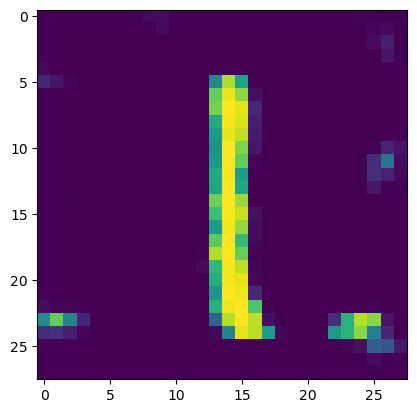

In [30]:
# inspect by eye because i'm stupid
i = 19
vector_1 = fixed_noise[i:i+1, :, :, :]

with torch.no_grad():
    fake_1 = G_final(vector_1).detach().cpu()

fake_1 = fake_1[0, 0, :, :]
plt.imshow(fake_1)

vector_np = vector_1.cpu().numpy()

# Save the vector to a text file
np.savetxt("vector_1.txt", vector_np.flatten())  # Flatten for 1D representation
print("Vector saved to vector_1.txt")

## **Samples of `1`s (hopefully)**

Vector loaded and reshaped: torch.Size([1, 100, 1, 1])


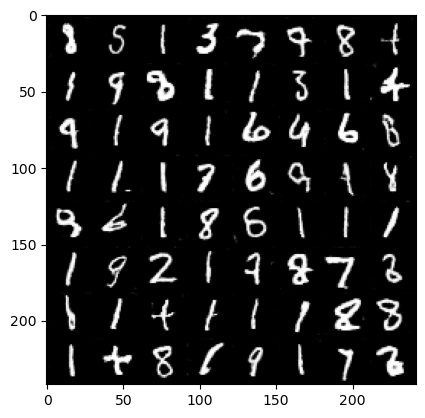

In [49]:
loaded_vector_np = np.loadtxt("vector_1.txt")

# Reshape it to the original shape of the noise vector
loaded_vector = torch.tensor(loaded_vector_np, device=device).view(1, -1, 1, 1)
print("Vector loaded and reshaped:", loaded_vector.shape)

sigma = 1.7  # Standard deviation for noise

size = [64, vector_1.shape[1], vector_1.shape[2], vector_1.shape[3]]

# Generate random noise tensor around the extracted vector
fixed_noise = vector_1 + torch.normal(mean=0.0, std=sigma, size=size, device=vector_1.device)

with torch.no_grad():
    fake = G_final(fixed_noise.float()).detach().cpu()
imggrid_preunlearn = vutils.make_grid(fake, padding=2, normalize=True)

plt.imshow(np.transpose(imggrid_preunlearn,(1, 2, 0)))

## **Unlearning thingamajic**

In [50]:
# Root directory for dataset
# move generated positive samples to this folder (any name)
# unlearnset/subfolder/
dataroot = "unlearnset/"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((28, 28)), 
        transforms.Grayscale()
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=30,
                                         shuffle=True)

print(len(dataloader))

5


In [51]:
def repulsion_loss(model_anchor, model, weight=5e8, batch_size=32):
    params_anchor = {n: p for n, p in model_anchor.named_parameters()}
    params = {n: p for n, p in model.named_parameters()}

    rl = 0
    for name in params:
        _rl = (params[name] - params_anchor[name])**2
        rl += _rl.sum()
    rl /= batch_size
    return weight*(rl**-1)


def make_image_plot(file_path, generator, examples=25, latent_size=512, dim=(5,5), figsize=(10,10)):
    noise= torch.randn(examples, latent_size).to(device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i + 1)
        image = generated_images[i].permute(1,2,0)
        plt.imshow(image,interpolation='nearest',cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close('all')


def make_train_summary_plot(histories, colors, labels):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(histories[0]) + 1), histories[0], color=colors[0], label=labels[0])
    plt.plot(range(1, len(histories[1]) + 1), histories[1], color=colors[1], label=labels[1])
    plt.title('Generator Loss During Adaptation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

def generate_folder(generator, folderpath, examples=25, latent_size=100):
    noise = torch.randn(examples, latent_size, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()


    for i in range(generated_images.shape[0]):
        file_name = f"{i}.jpg"
        image = generated_images[i].permute(1,2,0)
        image = image.numpy()
        image = image.reshape(image.shape[0], image.shape[1])
        plt.imsave(os.path.join(folderpath, file_name), image, cmap="gray")


def param_diff(model0, model1):
    params0 = {n: p for n, p in model0.named_parameters()}
    params1 = {n: p for n, p in model1.named_parameters()}

    param_diffs = []
    for name in params0:
        dparam = ((params0[name] - params1[name])**2).mean().detach().cpu()
        param_diffs.append(dparam**2)

    return param_diffs

In [52]:
num_epochs = 1100

c_optimizer = optimizerG.__class__.__name__ # Adam | SGD
# c_lr = str(optimizerD.param_groups[0]['lr']).replace(".", "") # 00002 | 00004 ...

print("-- Epochs: ", num_epochs)
print("-- Current z_dim: ", nz)
# print("-- Current optimizer & learning rate: ", c_optimizer, c_lr)
print("-- Is training netG: ", G_final.training)
print("-- Is training netD: ", D_final.training)
print("-- Device: ", device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
real_label = 1.0
fake_label = 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, _) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D_final.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D_final(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G_final(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D_final(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        loss_D_repulse = repulsion_loss(D_adapt, D_final, batch_size=b_size, weight=2e3)
        loss_D_fake = errD_fake + loss_D_repulse
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # loss_D_fake = repulsion_loss(, D_final, batch_size=b_size, weight=5e6)
        loss_D_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + loss_D_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        tG_start = time.time()
        G_final.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = G_final(noise)
        output = D_final(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        loss_G_repulse = repulsion_loss(G_adapt, G_final, batch_size=b_size, weight=2e3)
        loss_G = errG + loss_G_repulse
        # Calculate gradients for G
        loss_G.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 70 == 0:
            print('[%d/%d][%d/%d]\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                    errG.item(), D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G_final(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Lưu trọng số G tại epoch 10 và 50
    if epoch == 10 or epoch == 50:
        torch.save(G_final.state_dict(), f"{save_dir}/generator_unlearn_epoch_{epoch}.pth")

-- Epochs:  1100
-- Current z_dim:  100
-- Is training netG:  True
-- Is training netD:  True
-- Device:  cuda:0
Starting Training Loop...
[0/1100][0/5]	Loss_G: 4.4730	D(G(z)): 0.0212
[1/1100][0/5]	Loss_G: 0.0924	D(G(z)): 0.9289
[2/1100][0/5]	Loss_G: 0.9239	D(G(z)): 0.5003
[3/1100][0/5]	Loss_G: 0.8274	D(G(z)): 0.6463
[4/1100][0/5]	Loss_G: 0.2820	D(G(z)): 0.8131
[5/1100][0/5]	Loss_G: 0.8513	D(G(z)): 0.6000
[6/1100][0/5]	Loss_G: 0.1605	D(G(z)): 0.9046
[7/1100][0/5]	Loss_G: 0.9526	D(G(z)): 0.5547
[8/1100][0/5]	Loss_G: 0.2392	D(G(z)): 0.8263
[9/1100][0/5]	Loss_G: 0.5024	D(G(z)): 0.7209
[10/1100][0/5]	Loss_G: 0.5599	D(G(z)): 0.7130
[11/1100][0/5]	Loss_G: 0.9464	D(G(z)): 0.5109
[12/1100][0/5]	Loss_G: 0.4633	D(G(z)): 0.7911
[13/1100][0/5]	Loss_G: 0.3396	D(G(z)): 0.7787
[14/1100][0/5]	Loss_G: 1.6749	D(G(z)): 0.3719
[15/1100][0/5]	Loss_G: 0.8659	D(G(z)): 0.5540
[16/1100][0/5]	Loss_G: 0.5894	D(G(z)): 0.6662
[17/1100][0/5]	Loss_G: 0.4918	D(G(z)): 0.7081
[18/1100][0/5]	Loss_G: 0.6458	D(G(z)): 0.60

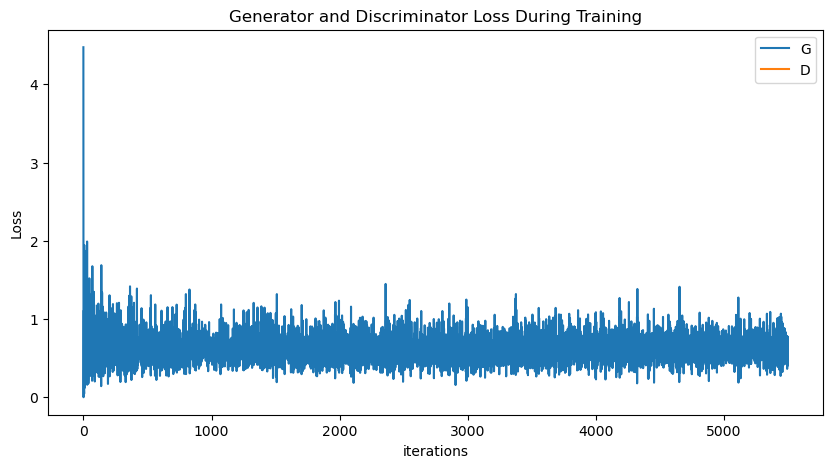

In [53]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.axis("off")

ims = [np.transpose(i,(1,2,0)) for i in img_list]
img = ax.imshow(ims[0])

def update(i):
    if i < 15:
        img.set_array(ims[0])
        ax.set_title(f"Unlearning features of digit '1', initial")
    elif i - 15 >= len(img_list) - 1:
        img.set_array(ims[-1])
        ax.set_title(f"Unlearning features of digit '1', final")
    else:
        img.set_array(ims[i - 15])
        ax.set_title(f"Unlearning features of digit '1', iteration: {(i - 15) * 70}")
    return [img]

ani = animation.FuncAnimation(
    fig, update, frames=len(img_list) + 30, interval=100, repeat_delay=1000, blit=True
)

# ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)
ani.save("unlearn.gif")
HTML(ani.to_jshtml())

(-0.5, 241.5, 241.5, -0.5)

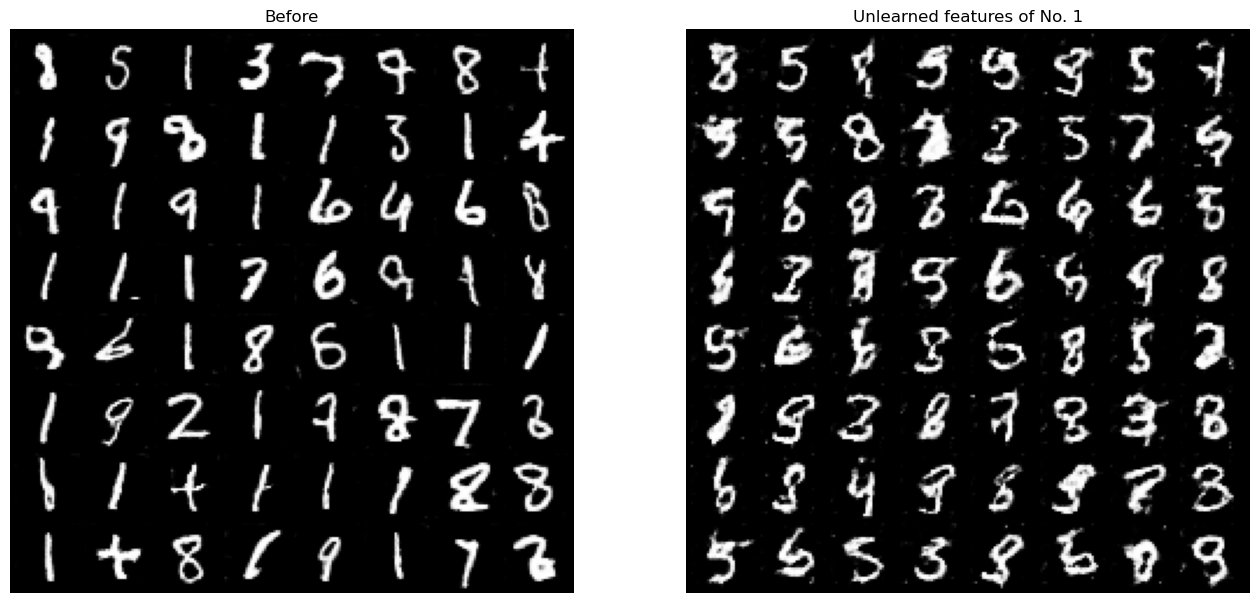

In [55]:

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(np.transpose(imggrid_preunlearn,(1, 2, 0)))
ax[0].set_title("Before")
ax[0].axis("off")

ax[1].imshow(ims[-1])
ax[1].set_title("Unlearned features of No. 1")
ax[1].axis("off")

In [56]:
torch.save(G_final.state_dict(), f"{save_dir}/generator_unlearned_mnist1.pth")
torch.save(D_final.state_dict(), f"{save_dir}/discriminator_unlearned_mnist1.pth")

In [57]:
generate_folder(G_final, folderpath="generated_unlearned_mnist1", examples=800)